In [1]:
import numpy as np 
import pandas as pd 
import gc
import utils as u
from plotnine import (ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_y_continuous, coord_flip, ggsave)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [2]:
dir = 'data/'
out = 'mid_output/'
train_numeric = dir + 'train_numeric.csv'
train_cate = dir + 'train_categorical.csv'
test_cate = dir + 'test_categorical.csv'

In [242]:
# get line information such as the number of line, station and features
features = pd.read_csv(train_cate, nrows = 1).columns.to_list()
features = list(set(features) - set(['Id']))
features = u.get_line_information(features)

number_stations = features.groupby('line')['station'].unique().apply(lambda x: len(x))
number_features = features.groupby('line')['station'].size()
print(number_stations)
print(number_features)


line
L0    15
L1     2
L2     3
L3    14
Name: station, dtype: int64
line
L0     323
L1    1227
L2     159
L3     431
Name: station, dtype: int64


# 

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371898832533144.svg


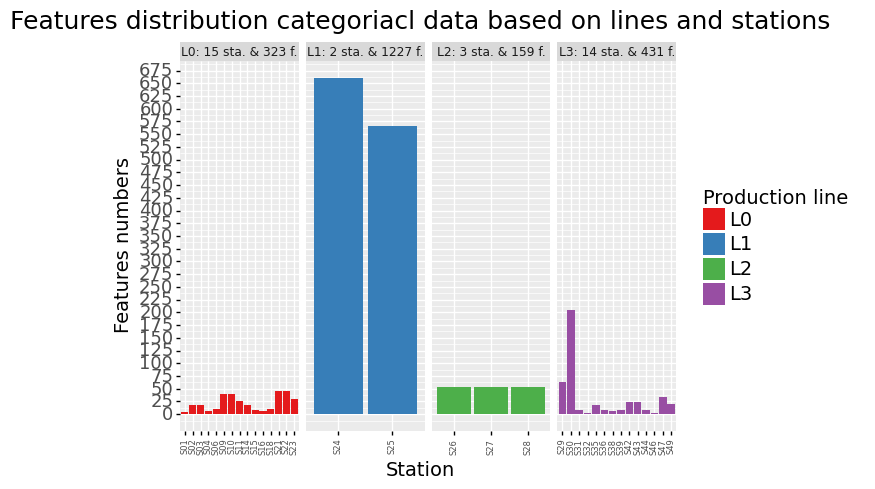

<ggplot: (-9223371898832533144)>

In [5]:
# draw the plot of the number of line, station and features
line_information = {'L0': "L0: 15 sta. & 323 f.",
                    'L1': "L1: 2 sta. & 1227 f.",
                    'L2': "L2: 3 sta. & 159 f.",
                    'L3': "L3: 14 sta. & 431 f."}

g = u.draw_feature_distribution(features, line_information, 'categoriacl data')
ggsave(file="date_station_number.svg", plot = g, width=10, height=8, dpi = 500,format = 'svg')
g

In [3]:
# load train label data
response = pd.read_csv(train_numeric, usecols = ['Response'])
response_prop = response.groupby('Response').size().reset_index(name='counts')
response_prop['props'] = response_prop['counts'].transform(lambda x: x / float(x.sum()))
label_count = response_prop['counts']

In [ ]:
# load raw data
cate_data = u.load_data(train_cate, 1.2*10**5, 1.2*10**6, usecols = pd.read_csv(train_cate, nrows = 1).columns)

In [ ]:
# generate the aggregation data for each feature

cate_cols = pd.read_csv(train_cate, nrows = 1).columns.to_list()
cate_cols = list(set(cate_cols) - set(['Id', 'Response']))
cate_of_col = len(cate_cols)

cate_explor = pd.DataFrame()

for i in range(cate_of_col - 1):
    col = []
    col.append(cate_cols[i])
    
    temp_cate = pd.DataFrame()
    temp_cate = pd.read_csv(train_cate, usecols = col)
    temp_cate = pd.concat([temp_cate, response], axis = 1).dropna(axis = 0, how = 'any')
    
    temp_cate = temp_cate.groupby('Response').size().reset_index(name='counts')
    ## --
    temp_cate = u.modified_groupby_data(temp_cate)
    ## --
    temp_cate = temp_cate.assign(
                props = temp_cate['counts'].transform(lambda x: x / float(x.sum())),
                WOE = np.log((temp_cate['counts'][1]/label_count[1]) / (temp_cate['counts'][0]/label_count[0])),
                IV = ((temp_cate['counts'][1]/label_count[1]) - (temp_cate['counts'][0]/label_count[0])) * np.log((temp_cate['counts'][1]/label_count[1]) / (temp_cate['counts'][0]/label_count[0])),
                feature = col[0],
                number_of_data = temp_cate['counts'].sum(),
                number_of_missing_data = len(response) - temp_cate['counts'].sum(),
                prop_of_missing = (len(response) - temp_cate['counts'].sum())/ len(response)
        )[temp_cate['Response'] == 1]
    
    cate_explor = pd.concat([cate_explor, temp_cate], axis = 0)
    del temp_cate
    gc.collect()

cate_explor.to_csv(out + 'cate_explor.csv')
cate_explor

In [243]:
# load above results and filter IV value which is higher than 0.02 
cate_explor = pd.read_csv(out + 'cate_explor.csv')
cate_select_features = cate_explor[(cate_explor['IV'] > 0.02) & (cate_explor['IV'] != np.inf)].sort_values('IV', ascending = False)
cate_select_features.to_csv(out + 'cate_explor_selected_features.csv')

In [ ]:
# selected features
features = (list(cate_select_features['feature']))
features.append('Id')
features = features[::-1]

# load data based on selected features
cate_train_selected_features = pd.read_csv(train_cate, usecols = features)
cate_test_selected_features = pd.read_csv(test_cate, usecols = features)

# save data
cate_train_selected_features.to_csv(out + 'cate_train_feature_IV_selected')
cate_test_selected_features.to_csv(out + 'cate_test_feature_IV_selected')

In [229]:
# data = pd.read_csv(out+'cate_information.csv')

In [ ]:
# calculate the number of factors occurred by each observation (row)
cate_train_count = u.cate_factor_count(train_cate, 2.4*10**5, 1.2*10**6)
cate_train_count['unique'] = cate_train_count.iloc[:, 1:].nunique(axis = 1, dropna=True)

In [ ]:
cate_train_count = pd.read_csv(out + 'cate_train_count_mid_selected.csv')

In [ ]:
(cate_train_data, bar_plot_data) = u.rowwise_feature_eng(cate_train_count, 6)

In [387]:
cate_train_count.to_csv(out + 'cate_train_count_mid_selected.csv')
cate_train_data.to_csv(out + 'cate_train_feature_factor_selected.csv')

c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
c:\py_venv\tutorial-venv\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plotnine-save-9223371913263650628.svg


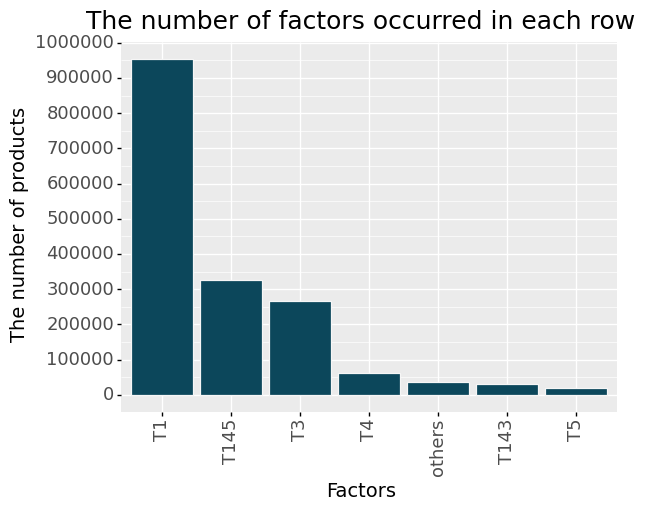

<ggplot: (-9223371913263650628)>

In [386]:
g = (
    ggplot(bar_plot_data)
    + geom_bar(aes(x = 'Index', y = 'count'), stat = "identity", color='#F6F6F6', fill='#0C475B')
    + theme(axis_text_x = element_text(angle = 90, size = 13),
            axis_text_y = element_text(size = 13),
            axis_title = element_text(size = 14),
            plot_title = element_text(size = 18)
           )
    + scale_y_continuous(breaks = range(0, 1200000, 100000))
    + labs(x = 'Factors', y = 'The number of products')
    + ggtitle('The number of factors occurred in each row')
)
ggsave(file="The number of factors occurred in each row.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g

In [389]:
cate_test_count = u.cate_factor_count(test_cate, 2.4*10**5, 1.2*10**6)
cate_test_count['unique'] = cate_test_count.iloc[:, 1:].nunique(axis = 1, dropna=True)

In [ ]:
(cate_test_data, bar_plot_data) = u.rowwise_feature_eng(cate_train_count, 6)

In [392]:
cate_test_count.to_csv(out + 'cate_test_count_mid_selected.csv')
cate_test_data.to_csv(out + 'cate_test_feature_factor_selected.csv')

## Feature importance

In [57]:
train_1 = pd.read_csv(out + 'cate_train_xgb_1-400(15).csv', index_col=0)
train_2 = pd.read_csv(out + 'cate_train_xgb_2-400(16).csv', index_col=0)
train_3 = pd.read_csv(out + 'cate_train_xgb_3-400(15).csv', index_col=0)
train_4 = pd.read_csv(out + 'cate_train_xgb_4-400(15).csv', index_col=0)
train_5 = pd.read_csv(out + 'cate_train_xgb_5-540(20).csv', index_col=0)

In [58]:
train_12 = pd.merge(train_1, train_2, how = 'left', on = 'Id')
train_123 = pd.merge(train_12, train_3, how = 'left', on = 'Id')
train_1234 = pd.merge(train_123, train_4, how = 'left', on = 'Id')
train_12345 = pd.merge(train_1234, train_5, how = 'left', on = 'Id')
cate_train = train_12345.copy()
del train_12, train_123, train_1234, train_12345
gc.collect()

59411

In [59]:
feats = list(cate_train.columns)
cate_train = pd.read_csv(train_cate, usecols = feats)
col = list(set(cate_train.columns) - set('Id'))

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,8,12,14,43,44,57,59,62,63,74,77,96,98,104,324,335,337,340,342,346,351,354,387,402,406,407,408,464,467,576,588,590,597,610,613,668,671,674,780,807,809,811,842,843,844,845,847,850,900,983,984,1054,1126,1183,1233,1288,1298,1300,1419,1429,1479,1527,1530,1539,1551,1553,1555,1557,1587,1602,1604,1606,1608,1640,1693,1985,1987,1996,1999,2002,2076,2088,2126,2128,2131) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
col = pd.read_csv(train_cate, nrows = 1).columns.to_list()
col = col[1601:2140]
col.append('Id')

In [ ]:
cate_train = u.load_data(train_cate, 2.5*10**5, 1.2*10**6, col)
# cate_test = u.load_data(train_cate, 2.5*10**5, 1.2*10**6, col)

In [60]:

for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    # cate_test[i] = cate_test[i].fillna('NA')
    # cate_test[i] = cate_test[i].map(lambda s: -1 if s not in le.classes_ else s)
    # le.classes_ = np.append(le.classes_, - 1)

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))
    # cate_test[i] = le.transform(cate_test[i])


In [61]:
feat_selected = pd.read_csv(out + 'cate_train_feature_factor_selected.csv', index_col=0)
cate_train = pd.merge(cate_train, feat_selected, how = 'left', on = 'Id')

In [62]:
print(cate_train.shape)
response = pd.read_csv(train_numeric, usecols = ['Response'])
data = pd.concat([cate_train, response], axis = 1)
print(data.shape)

(1183747, 99)
(1183747, 100)


In [64]:
np.random.seed(10)
data = data.sample(frac = 1.0)
gc.collect()
data.to_csv(out + 'temp_xgb_cate-6.csv')

In [65]:
X = data.drop(['Id', 'Response'], axis = 1)
y = data['Response']
print(X.shape)
print(y.shape)

(1183747, 98)
(1183747,)


In [93]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
scores = []
for tr_idx, va_idx in kf.split(X, y):
    tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
    tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]

    dtrain = xgb.DMatrix(tr_x, label = tr_y)
    dvalid = xgb.DMatrix(va_x, label = va_y)

    num_round = 50
    params = {'colsample_bytree':0.4, 
              'eta':0.01,
              'max_depth': 5,
              'subsample': 0.8,
              'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'random_state': 71,
              'silent': 0
            }

    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(params, dtrain, num_round, evals = watchlist, early_stopping_rounds = 10)
    va_pred = model.predict(dvalid)
    score = log_loss(va_y, va_pred)
    print('logss value: {}'.format(score))
    scores.append(score)
    del va_pred, score
    gc.collect()

print('avg_logloss:', np.mean(scores))


[09:48:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.68295	eval-logloss:0.68357
[1]	train-logloss:0.67293	eval-logloss:0.67403
[2]	train-logloss:0.66444	eval-logloss:0.66446
[3]	train-logloss:0.65607	eval-logloss:0.65543
[4]	train-logloss:0.64638	eval-logloss:0.64643
[5]	train-logloss:0.63797	eval-logloss:0.63748
[6]	train-logloss:0.62909	eval-logloss:0.62896
[7]	train-logloss:0.62082	eval-logloss:0.62031
[8]	train-logloss:0.61133	eval-logloss:0.61226
[9]	train-logloss:0.60346	eval-logloss:0.60389
[10]	train-logloss:0.59529	eval-logloss:0.59594
[11]	train-logloss:0.58757	eval-logloss:0.58812
[12]	train-logloss:

In [14]:
model.save_model("cate_xgb_model-5.json")

In [94]:
# model = xgb.Booster()
# model.load_model("cate_xgb_model-1.json")
fscore = model.get_score(importance_type = 'total_gain')

keys = list(fscore.keys())
values = list(fscore.values())
feat_imp = pd.DataFrame({'feature': keys, 'scores': values}, index=keys).sort_values(by = "scores", ascending=True)
feat_imp['feature'] = pd.Categorical(
feat_imp.feature, categories=pd.unique(feat_imp.feature))
feat_imp['score'] = feat_imp['scores'].transform(lambda x: (x/float(x.sum())*100))
# feat_imp.to_csv(out + 'numeric_xgb_feature_importance.csv')
feat_imp
  

,feature,scores,score
L2_S28_F3285,L2_S28_F3285,0.008606,0.000118
L1_S24_F717,L1_S24_F717,0.260468,0.003556
T5,T5,0.309470,0.004226
L1_S25_F2958,L1_S25_F2958,0.350464,0.004785
L1_S25_F2099,L1_S25_F2099,0.371094,0.005067
...,...,...,...
L2_S26_F3099,L2_S26_F3099,132.903625,1.814696
L1_S24_F1582,L1_S24_F1582,159.968750,2.184250
L1_S24_F1585,L1_S24_F1585,167.620377,2.288727
L3_S32_F3851,L3_S32_F3851,1665.656250,22.743249


In [96]:
features = list(feat_imp.iloc[-10:, 0])
features = list(set(features) - set(['T3', 'unique', 'T1']))
features

['L1_S24_F1593',
 'L2_S26_F3099',
 'L1_S24_F1589',
 'L1_S24_F1586',
 'L3_S32_F3851',
 'L3_S49_F4220',
 'L3_S49_F4225',
 'L3_S32_F3854',
 'L1_S24_F1585',
 'L1_S24_F1582']

In [103]:
# features = list(feat_imp.iloc[-20:, 0])
features.append('Id')
cate_train = pd.read_csv(train_cate, usecols = features)
cate_test = pd.read_csv(test_cate, usecols = features)

c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (842,844,845,847,850,1587,1985,1987,2128,2131) have mixed types.Specify dtype option on import or set low_memory=False.
c:\py_venv\tutorial-venv\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (842,844,845,847,850,1985,1987,2128,2131) have mixed types.Specify dtype option on import or set low_memory=False.


In [100]:
col = list(set(cate_train.columns) - set(['Id']))
for i in col:
    le = LabelEncoder()
    le.fit(cate_train[i].fillna('NA'))

    cate_test[i] = cate_test[i].fillna('NA')
    cate_test[i] = cate_test[i].map(lambda s: -1 if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, - 1)

    cate_train[i] = le.transform(cate_train[i].fillna('NA'))
    cate_test[i] = le.transform(cate_test[i])


In [78]:
# train_factor = pd.read_csv(out + 'cate_train_feature_factor_selected.csv', usecols = ['Id', 'T3', 'unique', 'T1'])
# test_factor = pd.read_csv(out + 'cate_test_feature_factor_selected.csv', usecols = ['Id', 'T3', 'unique', 'T1'])

In [104]:
# train = pd.merge(cate_train, train_factor, how = 'left', on = 'Id')
# test = pd.merge(cate_test, test_factor, how = 'left', on = 'Id')
cate_train.to_csv(out + 'cate_train_features.csv')
cate_test.to_csv(out + 'cate_test_features.csv')

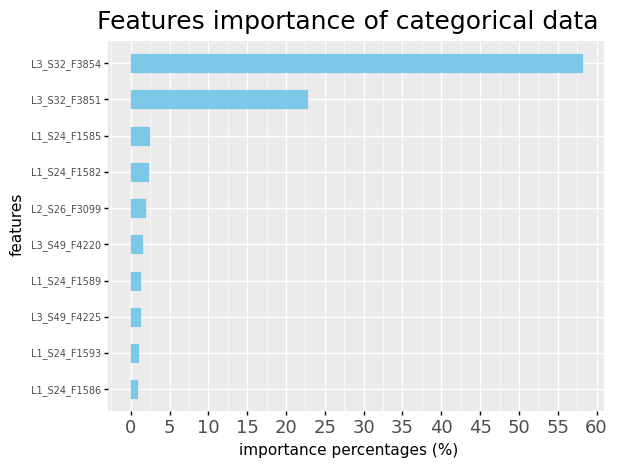

<ggplot: (-9223371870674990016)>

In [98]:
g = (
    ggplot(feat_imp.iloc[-10:, :])
    + geom_bar(aes(x = 'feature', y = 'score'), stat = "identity", color='#7cc8e9', fill='#7cc8e9', width = 0.5)
    + theme(axis_text_x = element_text(angle = 0, size = 13),
            axis_text_y=element_text(size=7),
            plot_title=element_text(size=18))
    + scale_y_continuous(breaks = range(0, 100, 5))
    + coord_flip()
    + labs(x = 'features',y = 'importance percentages (%)')
    + ggtitle('Features importance of categorical data')
)
# ggsave(file="Features importance of numeric data.svg", plot = g, width = 10, height = 8, dpi = 500, format = 'svg')
g